In this notebook we try to finetune GPT2-small
to match the behavior of a simple prompt over the tiny stories dataset.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

from persona_convergence import tiny_stories, utils

DEVICE = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
DEVICE

device(type='cuda')

### Load models

In [3]:
MODEL_ID = "gpt2"
model_base = GPT2LMHeadModel.from_pretrained(MODEL_ID).to(DEVICE).eval()
model_base.requires_grad_(False)
tokenizer: GPT2TokenizerFast = GPT2TokenizerFast.from_pretrained(MODEL_ID)

### Load dataset

In [4]:
SEQ_LEN = 128

ds_train = tiny_stories.load_ds(
    split="train[:1%]",
    tokenizer=tokenizer,
    seq_len=SEQ_LEN,
)
ds_val = tiny_stories.load_ds(
    split="validation",
    tokenizer=tokenizer,
    seq_len=SEQ_LEN,
)

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


### Test model behavior

In [5]:
n_new_tokens = 100
PREFIX = "This is a sad story. "
prompt = " ".join(ds_train["text"][2].split(" ")[:32])

print("Prompt:")
utils.print_with_wrap(prompt)

print()
print("Continuation:")
utils.print_with_wrap(
    utils.gen_text(model_base, tokenizer, prompt, max_new_tokens=n_new_tokens)
)

print()
print(f"Continuation ({PREFIX=}):")
utils.print_with_wrap(
    utils.gen_text(
        model_base, tokenizer, PREFIX + prompt, max_new_tokens=n_new_tokens
    )
)

Prompt:
One day, a little fish named Fin was swimming near the shore. He saw a big crab
and wanted to be friends. "Hi, I am Fin. Do you want to play?" asked

Continuation:
 the fish. "I am Fin," said Fin. "I am Fin."  Fin was a big fish, but he was not
a big fish. He was a big fish. He was a big fish. He was a big fish. He was a
big fish. He was a big fish. He was a big fish. He was a big fish. He was a big
fish. He was a big fish. He was a big fish. He was a big fish. He was

Continuation (PREFIX='This is a sad story. '):
 the fish. "No, I don't want to play," said Fin. "I just want to play." "I'm not
playing," said the fish. "I'm not playing," said Fin. "I'm not playing," said
Fin. "I'm not playing," said Fin. "I'm not playing," said Fin. "I'm not
playing," said Fin. "I'm not playing," said Fin. "I'm not playing," said Fin.
"I'm not


### Finetune models

In [6]:
BATCH_SIZE = 16

prefix_toks = tokenizer(PREFIX, return_tensors="pt").input_ids[0].to(DEVICE)
print(PREFIX)
print(prefix_toks)

dl_train = DataLoader(
    ds_train.remove_columns("text").with_format("torch"),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

dl_val = DataLoader(
    ds_val.remove_columns("text").with_format("torch"),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

This is a sad story. 
tensor([1212,  318,  257, 6507, 1621,   13,  220], device='cuda:0')


In [7]:
model_tuned = GPT2LMHeadModel.from_pretrained(MODEL_ID).to(DEVICE)
optimizer = torch.optim.Adam(model_tuned.parameters(), lr=5e-5)

In [8]:
model_tuned.train()
metrics: list[dict[str]] = []

step = 0
for epoch in range(1):
    pbar = tqdm(dl_train, leave=True)
    for batch in pbar:
        xs = batch["orig_input_ids"].to(model_base.device)
        first_toks_w_space = batch["first_token_w_space"].to(model_base.device)

        xs_with_prefix = torch.cat(
            [
                einops.repeat(
                    prefix_toks, "seq -> batch seq", batch=xs.shape[0]
                ),
                xs,
            ],
            dim=1,
        )
        xs_with_prefix[:, len(prefix_toks)] = first_toks_w_space[:, 0]

        with torch.no_grad():
            logits_base = model_base(xs_with_prefix, use_cache=False).logits

        logits_tuned = model_tuned(xs, use_cache=False).logits
        kl_div = F.kl_div(
            input=F.log_softmax(logits_tuned, dim=-1),
            target=F.log_softmax(logits_base[:, len(prefix_toks) :], dim=-1),
            log_target=True,
            reduction="batchmean",
        )

        optimizer.zero_grad()
        kl_div.backward()
        optimizer.step()

        cur_metrics = dict(
            kl_div=kl_div.item(),
            epoch=epoch,
            step=step,
        )
        metrics.append(cur_metrics)
        pbar.set_postfix(cur_metrics)

df = pd.DataFrame(metrics)

  0%|          | 0/1261 [00:00<?, ?it/s]

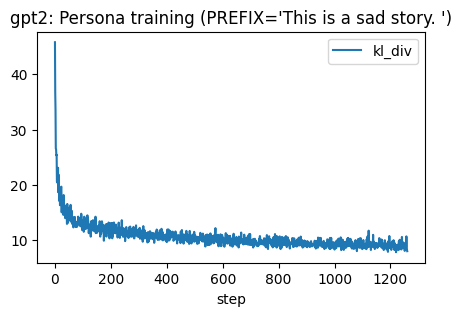

In [20]:
plt.figure(figsize=(5, 3))

df.kl_div.plot(label="kl_div")

plt.legend()
plt.xlabel("step")
plt.title(f"{MODEL_ID}: Persona training ({PREFIX=})")
plt.show()